In [1]:
!pip install nltk
!pip install spacy
!pip install gensim
!pip install pyLDAvis
# !pip install pandas==1.3.1 #New versions of pandas will produce errors in the code below :)

Looking in indexes: http://172.17.0.1:3143/root/pypi/+simple/
  Using cached http://172.17.0.1:3143/root/pypi/%2Bf/4fa/26829c5b00715/nltk-3.9.1-py3-none-any.whl (1.5 MB)
  Using cached http://172.17.0.1:3143/root/pypi/%2Bf/f2a/19f302cd1ce5d/regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (792 kB)
Looking in indexes: http://172.17.0.1:3143/root/pypi/+simple/
  Using cached http://172.17.0.1:3143/root/pypi/%2Bf/05d/8a4cbfdb90049/spacy-3.8.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.6 MB)
  Using cached http://172.17.0.1:3143/root/pypi/%2Bf/476/e3bd0d05f8c33/spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Using cached http://172.17.0.1:3143/root/pypi/%2Bf/196/284c9c446cc0c/spacy_loggers-1.0.5-py3-none-any.whl (22 kB)
  Using cached http://172.17.0.1:3143/root/pypi/%2Bf/5b9/a5109e29d43c7/murmurhash-1.0.11-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (134 kB)
  Using cached http://172.17.

In [2]:
!python -m spacy download en_core_web_sm

Looking in indexes: http://172.17.0.1:3143/root/pypi/+simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.0 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/tatmaw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tatmaw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
file_path = "news_data.csv"
news_data = pd.read_csv(file_path)

In [6]:
# Drop rows with missing titles
news_data = news_data.dropna(subset=['title']).reset_index(drop=True)

# Initialize stopwords and spaCy model
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [7]:
news_data

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20237,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20238,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20239,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20240,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [8]:
pd.__version__

'2.2.1'

In [9]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/tatmaw/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
# Define text preprocessing functions
def clean_text(text):
    """
    Remove punctuation, convert to lowercase, and clean text data.
    """
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

def tokenize_and_remove_stopwords(text):
    """
    Tokenize the text and remove stopwords.
    """
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

def lemmatize_tokens(tokens):
    """
    Lemmatize tokens using spaCy.
    """
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]

# Preprocess titles
def preprocess_title(title):
    """
    Full preprocessing pipeline for a single title.
    """
    cleaned = clean_text(title)
    tokens = tokenize_and_remove_stopwords(cleaned)
    lemmatized = lemmatize_tokens(tokens)
    return lemmatized

# Apply preprocessing to all titles
news_data['processed_title'] = news_data['title'].apply(preprocess_title)

# Create bigrams and trigrams
bigram = Phrases(news_data['processed_title'], min_count=5, threshold=100)
trigram = Phrases(bigram[news_data['processed_title']], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

def make_bigrams(texts):
    """
    Apply bigram model to tokenized texts.
    """
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    """
    Apply trigram model to tokenized texts.
    """
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Apply bigram and trigram models
news_data['processed_title'] = make_bigrams(news_data['processed_title'])
news_data['processed_title'] = make_trigrams(news_data['processed_title'])

# Save processed data to a new file
output_file = 'preprocessed_news_data.csv'
news_data.to_csv(output_file, index=False)

# Output success message
print(f"Preprocessed data saved to {output_file}")

Preprocessed data saved to preprocessed_news_data.csv


In [11]:
print(clean_text("Sample title!"))
print(tokenize_and_remove_stopwords(clean_text("Sample title!")))

sample title 
['sample', 'title']


In [12]:
print(news_data)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20237  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20238  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20239  20797  Macy’s Is Said to Receive Takeover Approach by...   
20240  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20241  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

In [13]:
import pandas as pd
news_data = pd.read_csv('preprocessed_news_data.csv')

In [14]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# Create a dictionary and corpus for LDA
texts = news_data['processed_title'].apply(eval).tolist()  # Convert string representation to list
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=50)

# View the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.024*"war" + 0.016*"report" + 0.014*"open" + 0.012*"border" + 0.012*"military" + 0.011*"crime" + 0.010*"breitbart" + 0.010*"question" + 0.009*"raise" + 0.008*"need"
Topic 1: 0.023*"new" + 0.022*"email" + 0.016*"election" + 0.014*"right" + 0.011*"break" + 0.011*"expose" + 0.011*"news" + 0.011*"comment" + 0.011*"video" + 0.010*"investigation"
Topic 2: 0.016*"wikileak" + 0.015*"campaign" + 0.014*"lose" + 0.014*"tell" + 0.012*"breitbart" + 0.010*"email" + 0.010*"election" + 0.009*"shoot" + 0.009*"presidential" + 0.009*"bill"
Topic 3: 0.022*"say" + 0.021*"go" + 0.021*"life" + 0.016*"face" + 0.015*"year" + 0.013*"breitbart" + 0.011*"leak" + 0.011*"let" + 0.010*"debate" + 0.010*"look"
Topic 4: 0.021*"vote" + 0.020*"want" + 0.016*"breitbart" + 0.015*"get" + 0.014*"find" + 0.013*"say" + 0.012*"stop" + 0.011*"turn" + 0.011*"woman" + 0.010*"man"
Topic 5: 0.016*"police" + 0.014*"charge" + 0.011*"case" + 0.010*"kill" + 0.009*"today" + 0.009*"help" + 0.009*"officer" + 0.008*"state" + 0.008

In [15]:
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.3790200693701843


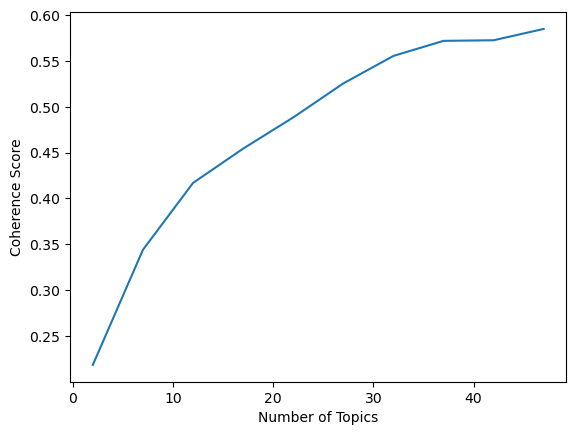

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, step=5):
    coherence_values = []
    for num_topics in range(2, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append((num_topics, coherencemodel.get_coherence()))
    return coherence_values

# Plot coherence values for different topic numbers
limit = 50
coherence_values = compute_coherence_values(dictionary, corpus, texts, limit)
x, y = zip(*coherence_values)
plt.plot(x, y)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()


In [17]:
fake_texts = news_data[news_data['label'] == 1]['processed_title'].apply(eval).tolist()
real_texts = news_data[news_data['label'] == 0]['processed_title'].apply(eval).tolist()

# Create dictionaries and corpora
fake_dict = Dictionary(fake_texts)
fake_corpus = [fake_dict.doc2bow(text) for text in fake_texts]
real_dict = Dictionary(real_texts)
real_corpus = [real_dict.doc2bow(text) for text in real_texts]

# Train separate LDA models
fake_lda_model = LdaModel(corpus=fake_corpus, id2word=fake_dict, num_topics=10, passes=50)
real_lda_model = LdaModel(corpus=real_corpus, id2word=real_dict, num_topics=10, passes=50)

print("Fake News Topics:")
for idx, topic in fake_lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

print("\nReal News Topics:")
for idx, topic in real_lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


Fake News Topics:
Topic 0: 0.020*"trump" + 0.014*"know" + 0.012*"thing" + 0.009*"say" + 0.009*"video" + 0.008*"stop" + 0.008*"protest" + 0.008*"time" + 0.008*"muslim" + 0.008*"take"
Topic 1: 0.033*"email" + 0.022*"vote" + 0.018*"wikileak" + 0.015*"campaign" + 0.014*"new" + 0.013*"break" + 0.010*"investigation" + 0.010*"news" + 0.009*"top" + 0.008*"expose"
Topic 2: 0.017*"trump" + 0.013*"comment" + 0.011*"face" + 0.010*"first" + 0.010*"information" + 0.010*"gold" + 0.007*"crisis" + 0.007*"history" + 0.006*"get" + 0.006*"speech"
Topic 3: 0.011*"life" + 0.011*"look" + 0.011*"happen" + 0.009*"evidence" + 0.009*"link" + 0.009*"head" + 0.008*"report" + 0.008*"new" + 0.008*"comment" + 0.007*"launch"
Topic 4: 0.011*"case" + 0.010*"fight" + 0.009*"pay" + 0.009*"woman" + 0.009*"hit" + 0.008*"arrest" + 0.008*"money" + 0.007*"comment" + 0.007*"foreign" + 0.007*"dead"
Topic 5: 0.015*"good" + 0.015*"food" + 0.013*"charge" + 0.013*"become" + 0.011*"health" + 0.011*"interview" + 0.010*"migrant" + 0.01

In [18]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)


In [19]:
def get_representative_texts(lda_model, corpus, texts, topic_num, top_n=5):
    """
    Get the most representative texts for a specific topic.
    """
    topic_texts = []
    for i, row in enumerate(lda_model[corpus]):
        sorted_topics = sorted(row, key=lambda x: x[1], reverse=True)
        if sorted_topics[0][0] == topic_num:
            topic_texts.append((texts[i], sorted_topics[0][1]))
    return sorted(topic_texts, key=lambda x: x[1], reverse=True)[:top_n]

# Example usage
representative_fake_texts = get_representative_texts(fake_lda_model, fake_corpus, fake_texts, topic_num=0)
representative_real_texts = get_representative_texts(real_lda_model, real_corpus, real_texts, topic_num=0)
print("Representative Fake News Texts:", representative_fake_texts)
print("Representative Real News Texts:", representative_real_texts)


Representative Fake News Texts: [(['comment', 'community', 'outraged', 'video', 'show', 'cop', 'throw', '16yo', 'girl', 'ibcamn'], 0.9181546), (['life', 'find', 'common_ground', 'white', 'man', 'muslim', 'woman', 'trump', 'paint', 'garage'], 0.91813624), (['minsk', 'meeting', 'hold', 'determine', 'status', 'donetsk', 'lugansk', 'expect', 'much', 'news'], 0.91811943), (['watch', 'exact', 'moment', 'commit', 'political', 'suicide', 'trump', 'rally', 'video'], 0.90997213), (['want', 'drug', 'baron', 'hand', 'say', 'life', 'run', 'get', 'much'], 0.9099698)]
Representative Real News Texts: [(['france', 'martel', 'teen', 'vogue', 'trump', 'support', 'oppress', 'latinos', 'big', 'change'], 0.91813487), (['review', 'lion', 'bring', 'tear', 'lose', 'boy', 'wipe', 'dry'], 0.8999308), (['castile', 'pull', 'time', 'year', 'often', 'minor', 'infraction'], 0.8874434), (['see', 'high', 'level', 'satisfaction', 'trump', 'administration'], 0.87141556), (['trump', 'dual', 'role', 'collide', 'opening', '

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

TypeError: type tuple doesn't define __round__ method

In [21]:
optimal_num_topics = 7  # Example: adjust based on your graph
optimal_model = model_list[x.index(optimal_num_topics)]
topics = optimal_model.show_topics(num_topics=optimal_num_topics, num_words=10, formatted=False)

for topic in topics:
    print(f"Topic {topic[0]}: {', '.join([word[0] for word in topic[1]])}")

NameError: name 'model_list' is not defined

In [20]:
texts = news_data['title'].tolist()  # Replace 'title' with the column holding the texts

In [23]:
# Ensure 'texts' is properly defined as the list of original titles or texts
texts = news_data['title'].tolist()  # Or replace 'title' with the appropriate column name

# Apply the function to get the dominant topic for each document
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Display the top rows of the DataFrame
df_topic_sents_keywords.head()

NameError: name 'format_topics_sentences' is not defined

In [21]:
# Extract lemmatized titles as a list of tokenized texts
data_lemmatized = news_data['processed_title'].tolist()

# Ensure it's in the right format (list of lists of tokens)
print(f"Sample Lemmatized Data: {data_lemmatized[:2]}")

Sample Lemmatized Data: ["['aide', 'even', 'see', 'tweet']", "['woman', 'campus', 'breitbart']"]


In [22]:
print(f"Sample of data_lemmatized: {data_lemmatized[:3]}")

Sample of data_lemmatized: ["['aide', 'even', 'see', 'tweet']", "['woman', 'campus', 'breitbart']", "['truth', 'get', 'fire']"]


In [23]:
# Ensure data_lemmatized is a list of lists of tokens
if isinstance(data_lemmatized[0], str):
    data_lemmatized = [doc.split() for doc in data_lemmatized]

print(f"Corrected data_lemmatized: {data_lemmatized[:3]}")

Corrected data_lemmatized: [["['aide',", "'even',", "'see',", "'tweet']"], ["['woman',", "'campus',", "'breitbart']"], ["['truth',", "'get',", "'fire']"]]


In [24]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# Verify the output
print(f"Sample Corpus: {corpus[:1]}")
print(f"Dictionary Sample: {list(id2word.items())[:10]}")

Sample Corpus: [[(0, 1), (1, 1), (2, 1), (3, 1)]]
Dictionary Sample: [(0, "'even',"), (1, "'see',"), (2, "'tweet']"), (3, "['aide',"), (4, "'breitbart']"), (5, "'campus',"), (6, "['woman',"), (7, "'fire']"), (8, "'get',"), (9, "['truth',")]


In [25]:
from gensim import corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# Print samples to verify
print(f"Sample Corpus: {corpus[:1]}")
print(f"Dictionary Sample: {list(id2word.items())[:10]}")

Sample Corpus: [[(0, 1), (1, 1), (2, 1), (3, 1)]]
Dictionary Sample: [(0, "'even',"), (1, "'see',"), (2, "'tweet']"), (3, "['aide',"), (4, "'breitbart']"), (5, "'campus',"), (6, "['woman',"), (7, "'fire']"), (8, "'get',"), (9, "['truth',")]


In [26]:
from gensim.models import CoherenceModel

# Define the number of topics
small_num_topics = 3

# Train LDA model with 3 topics
lda_small = gensim.models.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=small_num_topics,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

# Compute coherence score
coherence_model_small = CoherenceModel(model=lda_small, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_small = coherence_model_small.get_coherence()

# Print results
print(f"Coherence Score for 3 Topics: {coherence_small}")
lda_small.show_topics(formatted=False)

Coherence Score for 3 Topics: 0.3737262753673523


[(0,
  [("['comment',", 0.009620619),
   ("'email',", 0.007036948),
   ("'police',", 0.006759553),
   ("'get',", 0.006583619),
   ("'kill',", 0.006546286),
   ("'show',", 0.006403214),
   ("'say']", 0.0056400704),
   ("'year',", 0.004689519),
   ("'go',", 0.004293015),
   ("'child',", 0.003985449)]),
 (1,
  [("['trump',", 0.024956845),
   ("'new',", 0.010255162),
   ("'say',", 0.008279119),
   ("'campaign',", 0.0066323252),
   ("'time',", 0.0050517926),
   ("'first',", 0.0048056156),
   ("'woman',", 0.004439967),
   ("'man',", 0.004265376),
   ("'video']", 0.004212472),
   ("['watch',", 0.00412131)]),
 (2,
  [("'trump',", 0.037252128),
   ("'breitbart']", 0.02398761),
   ('[]', 0.014020111),
   ("'election',", 0.0077525303),
   ("'call',", 0.006327559),
   ("'trump']", 0.006292456),
   ("'report',", 0.0051631653),
   ("'vote',", 0.004911159),
   ("['say',", 0.0047264555),
   ("'day',", 0.0045842864)])]

In [ ]:
# Define the number of topics
large_num_topics = 1000

# Train LDA model with 1000 topics
lda_large = gensim.models.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=large_num_topics,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

# Compute coherence score
coherence_model_large = CoherenceModel(model=lda_large, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_large = coherence_model_large.get_coherence()

# Print results
print(f"Coherence Score for 1000 Topics: {coherence_large}")
lda_large.show_topics(formatted=False)


/opt/conda/lib/python3.11/site-packages/gensim/models/ldamodel.py:850: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [ ]:
# Function to calculate coherence values for a range of topics
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=100,
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Run the function for a range of topics
start = 2
limit = 40
step = 2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

# Plot the coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.show()


In [ ]:
# Split the data
fake_news = news_data[news_data['label'] == 'Fake']
real_news = news_data[news_data['label'] == 'Real']

# Preprocess the titles for each subset
fake_titles = [preprocess_title(title) for title in fake_news['title']]
real_titles = [preprocess_title(title) for title in real_news['title']]

# Create dictionaries and corpora for each subset
fake_id2word = corpora.Dictionary(fake_titles)
fake_corpus = [fake_id2word.doc2bow(text) for text in fake_titles]

real_id2word = corpora.Dictionary(real_titles)
real_corpus = [real_id2word.doc2bow(text) for text in real_titles]

# Train LDA models for each subset
fake_lda = gensim.models.LdaModel(corpus=fake_corpus,
                                  id2word=fake_id2word,
                                  num_topics=optimal_num_topics,
                                  random_state=100,
                                  update_every=1,
                                  chunksize=100,
                                  passes=10,
                                  alpha='auto',
                                  per_word_topics=True)

real_lda = gensim.models.LdaModel(corpus=real_corpus,
                                  id2word=real_id2word,
                                  num_topics=optimal_num_topics,
                                  random_state=100,
                                  update_every=1,
                                  chunksize=100,
                                  passes=10,
                                  alpha='auto',
                                  per_word_topics=True)

# Compare topic keywords
print("Fake News Topics:")
print(fake_lda.print_topics())

print("\nReal News Topics:")
print(real_lda.print_topics())


In [ ]:
# Format dominant topics for titles
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, 
                                                   corpus=corpus, 
                                                   texts=data_lemmatized)

# Format the DataFrame for readability
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Display representative examples for each topic
for topic_num in range(optimal_num_topics):
    print(f"\nTopic {topic_num}:")
    print(df_dominant_topic[df_dominant_topic['Dominant_Topic'] == topic_num].head(3))


In [ ]:
print("Fake News Data Sample:")
print(fake_news.head())

print("\nReal News Data Sample:")
print(real_news.head())